In [1]:
#import modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import h5py
import tensorflow.compat.v1 as tf
import tensorflow as tf2

from DlModels import DlModels
from TrainDL import TrainDL
from DataLoader import DataLoader

In [2]:
# tf.test.is_gpu_available()

In [3]:
tf.config.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.backend.set_floatx('float32') #for memory use

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


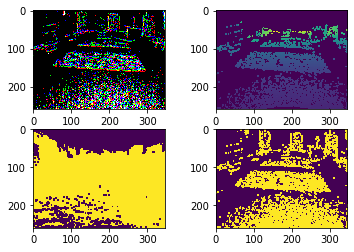

In [4]:
#test batching
data_loader = DataLoader('indoor_flying_augmented.hdf5')

event_images, depth_images, mask_1, mask_2 = data_loader.load_all()

fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.imshow(np.array(event_images[10][:,:,0:3]))
ax.autoscale(True)
ax2 = fig.add_subplot(2, 2, 2, sharex=ax, sharey=ax)
ax2.imshow(np.array(depth_images[10]))
ax2.autoscale(True)
ax3 = fig.add_subplot(2, 2, 3, sharex=ax, sharey=ax)
ax3.imshow(np.array(mask_1[10]))
ax3.autoscale(True)
ax4 = fig.add_subplot(2, 2, 4, sharex=ax, sharey=ax)
ax4.imshow(np.array(mask_2[10]))
ax4.autoscale(True)
plt.show()


In [5]:
epochs = 150
batch_size = 8
base_learning_rate = 0.001
learning_decay_rate = 30
learning_decay_factor = 0.5
data_loader = DataLoader('indoor_flying_augmented.hdf5')

tf.compat.v1.disable_eager_execution()
input_image = tf.placeholder(tf.float32, [None, None, None, 9], name='input_image')
depth_image = tf.placeholder(tf.float32, [None, None, None, 1], name='depth_image')
mask_image_1 = tf.placeholder(tf.float32, [None, None, None, 1], name='mask_image_1')
mask_image_2 = tf.placeholder(tf.float32, [None, None, None, 1], name='mask_image_2')
learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

sess = tf.Session()

# Build NN using load_vgg, layers, and optimize function
nn_last_layer = DlModels.vggDecoder(input_image, DlModels.vgg11)

train_op, loss = TrainDL.NormalizedHuberOptimize(nn_last_layer, depth_image, mask_image_1, mask_image_2, learning_rate)

# Train NN using the train_nn function
TrainDL.train_nn(sess, epochs, batch_size, data_loader, train_op, loss, input_image, depth_image, mask_image_1, mask_image_2, learning_rate, base_learning_rate, learning_decay_rate, learning_decay_factor)
        
# save trained model
saver = tf.train.Saver()
saver.save(sess, './model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Training...

EPOCH 1 ...
Loss: =
0.7982083344459534

EPOCH 2 ...
Loss: =
0.5297259974479676

EPOCH 3 ...
Loss: =
0.48887075662612917

EPOCH 4 ...
Loss: =
0.4120002603530884

EPOCH 5 ...
Loss: =
0.3999255335330963

EPOCH 6 ...
Loss: =
0.36120849013328554

EPOCH 7 ...
Loss: =
0.34143970608711244

EPOCH 8 ...
Loss: =
0.45096884965896605

EPOCH 9 ...
Loss: =
0.32805654406547546

EPOCH 10 ...
Loss: =
0.31930861234664915

EPOCH 11 ...
Loss: =
0.31374333024024964

EPOCH 12 ...
Loss: =
0.2880269491672516

EPOCH 13 ...
Loss: =
0.2613910412788391

EPOCH 14 ...
Loss: =
0.24333420157432556

EPOCH 15 ...
Loss: =
0.23352296829223632

EPOCH 16 ...
Loss: =
0.23111695051193237

EPOCH 17 ...
Loss: =
0.20012600600719452

EPOCH 18 ...
Loss: =
0.18517859756946564

EPOCH 19 ...
Loss: =
0.18558339953422545

EPOCH 20 ...
Loss: =
0.16526467978954315

EPOCH 21 ...
Loss: =
0.16497118413448333

EPOCH 22 ...
Loss: =
0.1433690190315246

'./model'

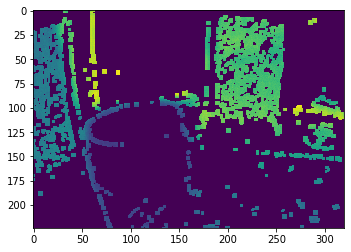

In [10]:
sample_image = event_images[70][0:224, 0:320, :]
est_depth = sess.run([nn_last_layer], feed_dict={input_image: sample_image.reshape(1, 224, 320, 9)})

#plt.imshow(est_depth[0].reshape(target_height, target_width))
plt.imshow(np.multiply(mask_2[70][0:224, 0:320],  est_depth[0].reshape(224, 320)))

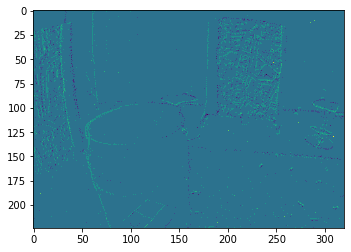

In [11]:
plt.imshow(sample_image[:,:,0])

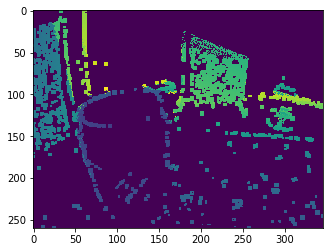

In [12]:
plt.imshow(depth_images[70])

In [20]:
#Convert to pointcloud
import open3d
from open3d import geometry
from open3d import visualization
import cv2
g = open3d.camera.PinholeCameraIntrinsic()
g.set_intrinsics(346, 260, 226.0181418548734, 225.7869434267677, 174.5433576736815, 124.21627572590607)

sample_image = event_images[40][0:224, 0:320, :]
est_depth = sess.run([nn_last_layer], feed_dict={input_image: sample_image.reshape(1, 224, 320, 9)})

padded_array = np.zeros((260, 346))
padded_array[:224, :320] = np.multiply(mask_2[40][0:224, 0:320],  est_depth[0].reshape(224, 320))
#padded_array[:224, :320] = np.multiply(mask_2[80][0:224, 0:320],  depth_images[80][:224, :320])
image = geometry.Image(np.float32(padded_array))

pointcloud = geometry.PointCloud.create_from_depth_image(image, g, depth_scale=1.0)
visualization.draw_geometries([pointcloud])
open3d.io.write_point_cloud("copy_of_fragment.pcd", pointcloud)

True